In [1]:
# 3/3/24 Mermin Bell 10 qubits
# importing all required libraries
import supermarq
import qiskit
import qiskit_superstaq as qss
from qiskit.visualization import plot_histogram
import os
import json
import numpy as np
import matplotlib.pyplot as plt


# defining all the variables here
Q = 10 # number of qubits
x = 64 # defining shot increment
nc = x # setting unchanging value for the loop
time = 30 # setting the normalization value
filename = "mermin_bell" # setting universal filename to avoid having to set differently
foldername = "Mermin Bell" + " " + str(Q) # setting universal folder name to avoid having to change it anywhere else
benchmark = "SupermarQ" # setting universal benchmark name to avoid having to change it everywhere else
bs_var_dict = {} # empty dict to hold all values of bs_var to see how it changes over time
p_var_dict = {} # empty dict to hold all vaues of p_var to see how it changes over time
score_dict = {} # dict that will observe the score at each shot interval

# added variance function instead of having to run it together
def variance(shots, b_name, fo_name, f_name):
    # load the output distribution from the json file
    file_path = '/home/aadi/Documents/Neutral-Atom-Technology/Step 1/' + str(b_name) + '/' + str(fo_name) + '/64 shot interval/' + str(f_name) + '_counts_' + str(shots) + '_shots.json' 
    with open(file_path, 'r') as file:
        output_distribution = json.load(file)

    # convert the dictionary keys to a list and probabilities to a separate list
    states = list(output_distribution.keys())
    probabilities = list(output_distribution.values())

    # this sets the probability values to 1 instead of the shot number
    probabilities = [x/shots for x in probabilities]
    
    # random sampling of basis states based on probability and setting them equal to a list
    sample = np.random.choice(states, size=shots, p=probabilities)

    # random sampling of the probabilites list based on probabilty and setting them equal to a list
    prob_sample = np.random.choice(probabilities, size=shots, p=probabilities)

    # change binary to ints
    int_sample = [int(b, 2) for b in sample]
    # int_sample = [int(b.replace(" ", ""), 2) for b in sample]

    # calculating the variance and printing out the results
    sample_var = np.var(int_sample)
    # print("The sample variance is: " + str(sample_var))
    prob_var = np.var(prob_sample)
    # print("The sample variance using probability is : " + str(prob_var))
    
    
    return int(sample_var), prob_var

In [2]:
# connecting api key from my account to simulate the circuits
api_key = "d354451b8ab536a6b3d92b3207b0fb15626e8c11355217ca121ee5a9193c3bd0"
provider = qss.SuperstaqProvider(api_key)
# making sure to not run out of balance
print(provider.get_balance())

# setting circuit name to avoid having to change it everytime
name = "mermin_bell"

20.00 credits


In [3]:
# defining which circuit I want to use and how many qubits
qc = supermarq.mermin_bell.MerminBell(num_qubits=10)
qc_circuit = qc.qiskit_circuit()

In [4]:
# setting the shot interval
x = 64

# setting up a simple while loop
while x<= 1024:   
    # setting the simulator that we will use to simulate our circuit (the default is ss_unconstrained_simulator)
    backend = provider.get_backend("ibmq_statevector_simulator")
    job_qss = backend.run(qc_circuit, shots=x, method="dry-run")

    # gettng the results of the simulation 
    job = job_qss.result()

    # getting the counts and printing them
    counts = job.get_counts()
    
    # getting accuracy to make sure this is accurate
    score = qc.score(counts)
    print(score)
    
    # creating a dictionary with outputs
    data = {
        'counts': counts,
        'accuracy': score
    }

    # logging results into a json file
    with open(name + '_counts_' + str(x) + '.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        
    x += 64

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
{'1000000000': 1024}


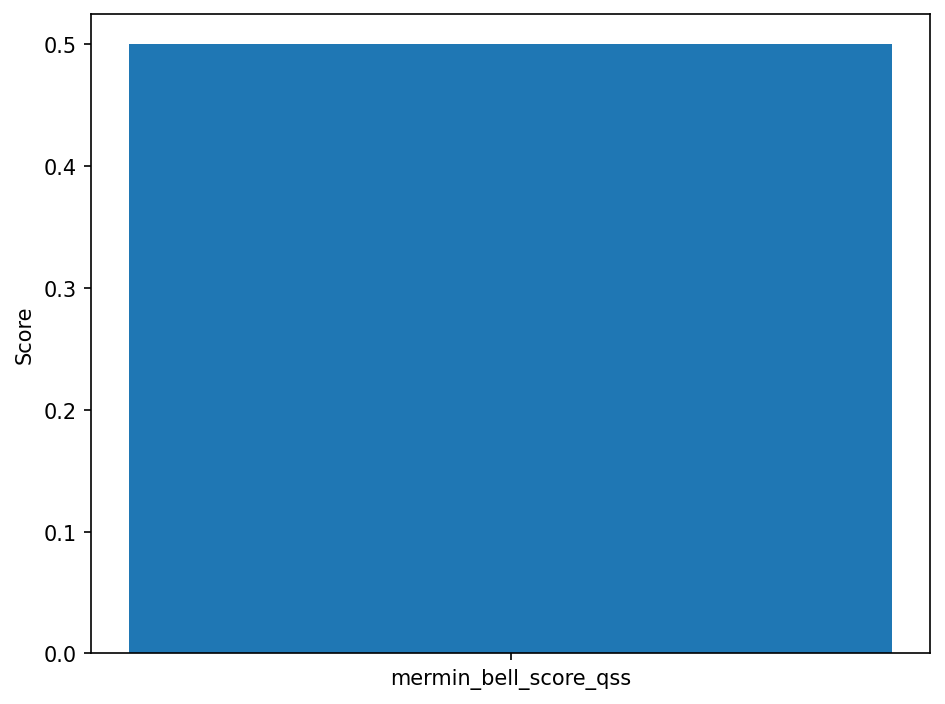

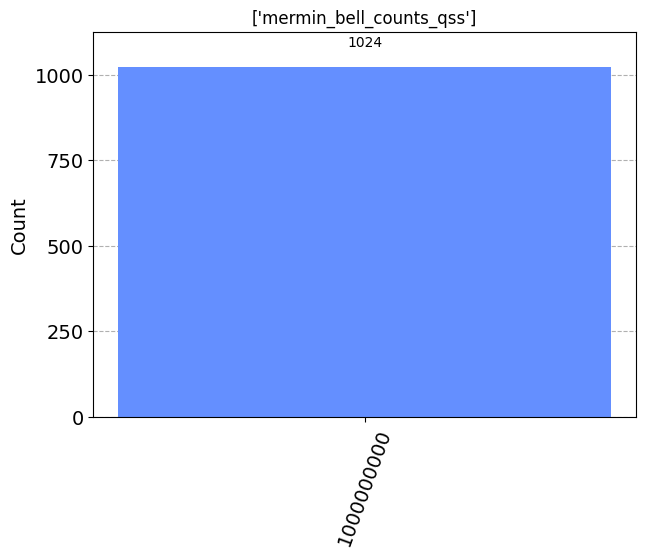

In [5]:
# measuring and getting fidelity of the result       
score = qc.score(counts)
print(score)
print(counts)

# plotting a bar chart of the benchmark results
supermarq.plotting.plot_results([score], [name + "_score_qss"])

# plotting a bar chart of the counts results
plot_histogram(counts, title=[name + "_counts_qss"])